# Development Notebooks

---

### Adjust Probabilities Using :
 - WSE's at Breach Location from No Breach Scenario 
 - Raw Probabilities calculating from Performance Curves
 - Monte Carlo Sampling

Contributors:

slawler@dewberry.com <b/>

leo.kreymborg@atkinsglobal.com


---


In [1]:
import os, sys, time, glob, re
%matplotlib inline
import pandas as pd
import numpy as np
sys.path.append('../core')
from breach_sim import *
pd.options.mode.chained_assignment = None #Add the slice from dataframe warnings
pd.options.display.max_rows = 150

## Input Data

 1. Root Directory
 2. Data File
 3. Output File Name
 
__User Defined:__ 

In [2]:
root_dir = r"C:\Users\slawler\Desktop"
control_file = r'DC_F01.xlsx'

##### Auto-populated variables

In [3]:
output_results =f"weighted_results_{control_file.replace('Control_File_','').replace('.xlsx','')}.csv"          
raw_prob_table = f"{control_file.replace('Control_File_','').replace('.xlsx','')}_raw_prob_table.csv"
one_breach_sim_results_table =  f"{control_file.replace('Control_File_','').replace('.xlsx','')}_breach_sim_results.csv"
#n_breaches_sim_results_table = os.path.join(output_dir, 'multibreach_sim_results.csv')

In [4]:
wses = pd.read_excel(os.path.join(root_dir, control_file), sheet_name='WSEs_at_Breach_Locations', index_col=0)
breaches=wses.columns
wses.head(2)

,B01,B02,B03,B04,B05,B06,B07,B08,B09
Event,,,,,,,,,
E0001,3.9617619999999998,3.3742093999999998,2.7615314,2.7615688000000000,2.7646413000000001,5.2394480000000003,7.5925956000000001,5.3431949999999997,-9999.0
E0002,4.1057395999999997,3.4845809999999999,2.8297946,2.8298347000000001,2.8327170000000002,5.2395199999999997,7.5925956000000001,5.3432469999999999,-9999.0


### Read in Weights from Spreadsheet
Raw weights computed for each event simulated

In [5]:
weights = pd.read_excel(os.path.join(root_dir, control_file), sheet_name='Event_Weights', index_col=0)
weights.head(3)

,Recurrence Interval,Model Prob,Overall Weight
Event,,,
E0001,2.0730996267629660,0.4823694853302572,0.0355943626728190
E0002,2.2303914214645628,0.4483517961808517,0.0327743489593255
E0003,2.3996173790790549,0.4167331045017636,0.0304630343988508


### Read in Fragility Curve Data from Spreadsheet

*Probability above Levee Crest = 1, not plotted*

In [6]:
fragility_data = pd.read_excel(os.path.join(root_dir, control_file), sheet_name='Levee_Fragility_Curves', skiprows=1)
fragility_data = fragility_data.T

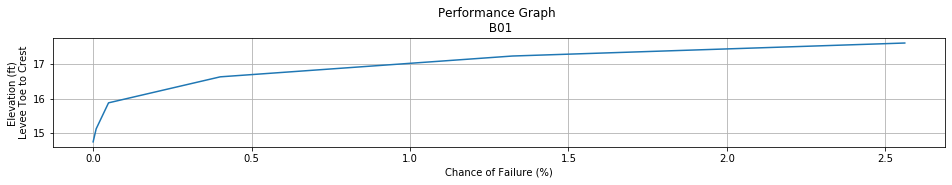

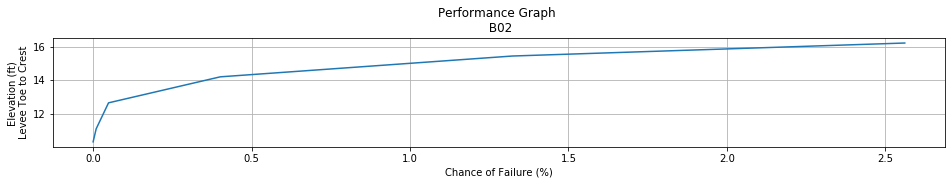

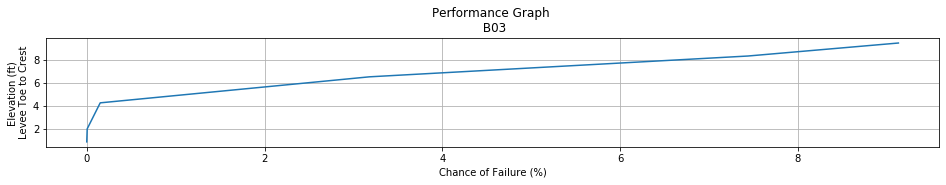

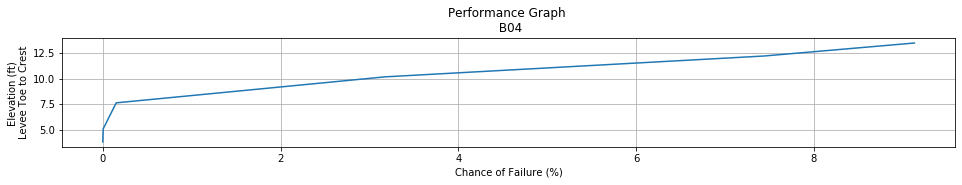

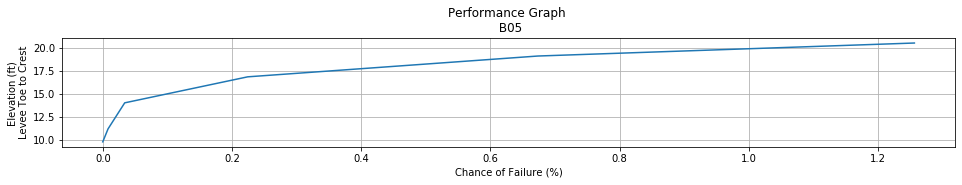

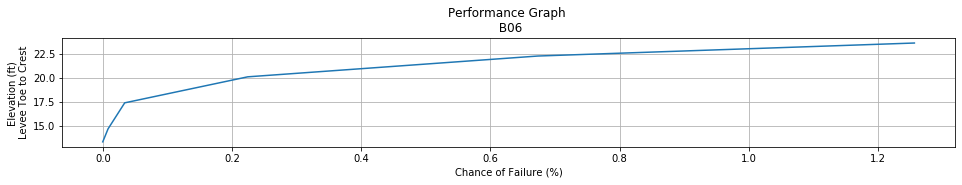

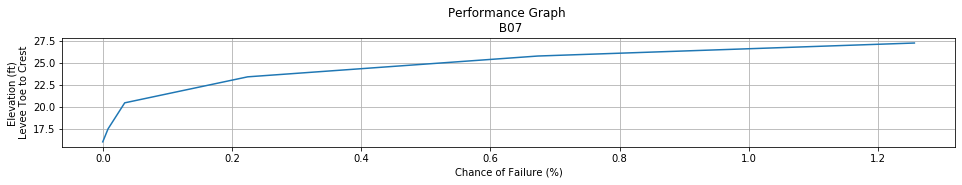

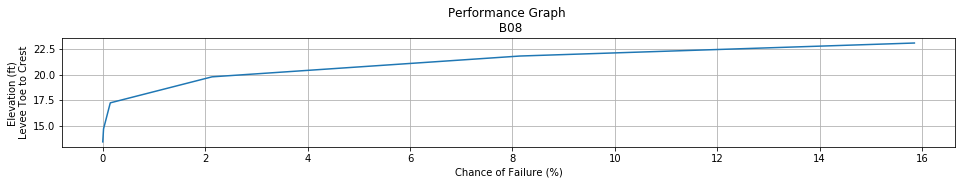

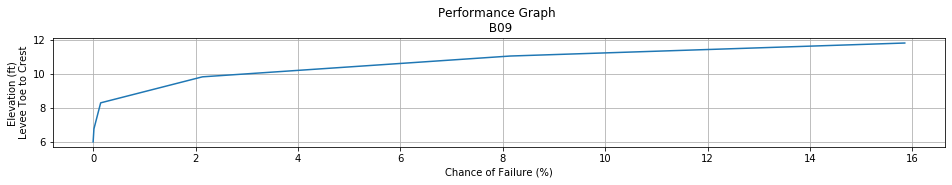

In [7]:
for breach_location in breaches:
    plot_performance(fragility_data, breach_location)

### Compute Probabilities for each Event using Performance Cuves & No-Breach WSE's

Write Raw Probabilites to table & save as text file

In [8]:
df_raw_probs = compute_raw_prob(wses, fragility_data, raw_prob_table)
df_raw_probs.to_csv(raw_prob_table, sep='\t')
df_raw_probs.head(3)

,RawProb_B01,RawProb_B02,RawProb_B03,RawProb_B04,RawProb_B05,RawProb_B06,RawProb_B07,RawProb_B08,RawProb_B09
Event,,,,,,,,,
E0001,0.0,0.0,0.0005327361186178,0.0,0.0,0.0,0.0,0.0,0.0
E0002,0.0,0.0,0.0005770938876408,0.0,0.0,0.0,0.0,0.0,0.0
E0003,0.0,0.0,0.0006521262217726,0.0,0.0,0.0,0.0,0.0,0.0


### Run MC Simulation to Compute Final Probabilities

In [9]:
# Read in Raw Probability Table (created in function compute_raw_prob() above)
run2data, nbreaches = readtable(raw_prob_table)

In [10]:
# Simulate a Single Breach set of probabilities
df_1 = run_sim(run2data, nbreaches, one_breach_sim_results_table, multi_breach=False, print_stdout=False)
df_1.head()

# Simulate a Multi Breach set of probabilities
#df_n = run_sim(run2data, nbreaches, n_breaches_sim_results_table, multi_breach=True, print_stdout=False)


Total Compute time: 0:01:02.519542
Results written to DC_F01_breach_sim_results.csv


,Event,Chance,BreachCombo
0,E0001,0.00052,B03
1,E0001,0.99948,_nobreach
2,E0002,0.00054,B03
3,E0002,0.99946,_nobreach
4,E0003,0.00082,B03


### Find unique event-breach pairs to determine minimum # of sims required

In [11]:
get_required_sims_1 = get_required_sims(df_1)
df_1.set_index('Event', inplace=True)
df_1.tail(3)

#print('\nMulti Breach Analysissaved to {}'.format(n_breaches_sim_results_table))
#get_required_sims_n = get_required_sims(df_n)

Total # of Breach Simulations required: 427


,Chance,BreachCombo
Event,,
E0100,0.00386,B08
E0100,0.19948,B09
E0100,0.00000,_nobreach


### Query results to compare probabilites computed for single vs multiple breaches
Verify results look appropriate

In [12]:
df_1.head(3)

,Chance,BreachCombo
Event,,
E0001,0.00052,B03
E0001,0.99948,_nobreach
E0002,0.00054,B03


In [13]:
combined_data = {}
for event in weights.index:
    event_weight = weights.loc[event,'Overall Weight']
    chance = pd.Series(df_1.loc[event, 'Chance']).values
    model = pd.Series(df_1.loc[event, 'BreachCombo']).values
    final_weight = event_weight*chance
    combined_data[event] = dict(zip(model, final_weight))

In [14]:
mc_results = pd.DataFrame.from_dict(combined_data, orient='index')
mc_results.head(3)

,B03,_nobreach,B04,B02,B09,B05,B01,B08,B06,B07
E0001,0.0000185090685899,0.0355758536042291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E0002,0.0000176981484380,0.0327566508108875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E0003,0.0000249796882071,0.0304380547106437,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
update_col_names = [col.replace('-','') for col in mc_results.columns]
for i, col in enumerate(mc_results.columns):
    if col=='_nobreach':
        mc_results.rename(columns={col:'NBR'}, inplace=True)
    else:
        mc_results.rename(columns={col: update_col_names[i]}, inplace=True)
        
mc_results.replace(np.nan, '', inplace=True)
mc_results.replace(0, '', inplace=True)
#results

In [18]:
mc_results

,B03,Base,B04,B02,B09,B05,B01,B08,B06,B07
E0001,0.0000185090685899,0.03557585360422909,,,,,,,,
E0002,0.0000176981484380,0.03275665081088748,,,,,,,,
E0003,0.0000249796882071,0.03043805471064373,,,,,,,,
E0004,0.0000164225367297,0.02829829596270584,,,,,,,,
E0005,0.0000186857134446,0.02629922054649523,,,,,,,,
E0006,0.0000227495793972,0.02443916375097149,,,,,,,,
E0007,0.0000215999684009,0.02271520887468356,,,,,,,,
E0008,0.0000211333622757,0.02111222891340429,,,,,,,,
E0009,0.0000214108635267,0.01962158319766371,,,,,,,,
E0010,0.0000202660799463,0.01823746360143018,,,,,,,,


In [19]:
all_events={}
for event in mc_results.index:
    for col in mc_results.columns:
        value = mc_results.loc[event,col]
        if value != '':
            all_events[col+'-'+event] = value
            
weighted_results = pd.DataFrame(data=list(all_events.values()), 
                                index=list(all_events.keys()), 
                                columns = ['Weight'])
weighted_results.head(4)

,Weight
B03-E0001,0.0000185090685899
Base-E0001,0.0355758536042291
B03-E0002,0.0000176981484380
Base-E0002,0.0327566508108875


In [20]:
breach_runs = [run for run in list(weighted_results.index) if 'NBR' not in run]
print('{} Additional Runs required for Breach Scenarios'.format(len(breach_runs)))

427 Additional Runs required for Breach Scenarios


##### Adjust the weight by the breach number

In [21]:
df=weighted_results.copy(deep=True)
df['idx']=df.index
df['Run']=df.idx.apply(lambda x: x.replace('-E','_E'))
df[['RunType','Events']] = df['Run'].str.split('_E',expand=True)
df['Events'] = pd.to_numeric(df['Events'])
df['Type']=df.RunType.apply(lambda x: ''.join([i for i in x if not i.isdigit()]))
df.head(3)

,Weight,idx,Run,RunType,Events,Type
B03-E0001,0.0000185090685899,B03-E0001,B03_E0001,B03,1,B
Base-E0001,0.0355758536042291,Base-E0001,Base_E0001,Base,1,Base
B03-E0002,0.0000176981484380,B03-E0002,B03_E0002,B03,2,B


In [22]:
event_lst=list(set(df['Events']))

#Total weight for each event
wtotal=[np.sum(df[df['Events']==e]['Weight'].values) for e in event_lst] 
    
df1=df[df.Type=='B'].copy(deep=True) #Truncate the dataframe to only breach events
df1['BreachNum']=df1['RunType'].apply(lambda x: int(re.findall(r'\d+', x)[0]))
num_breaches=df1['BreachNum'].max()
print('Max Breaches:', num_breaches)

df1['Weight']=df1['Weight']/num_breaches #Divide the weight of breach events by the number of breaches
df1=df1.drop(['idx','RunType', 'Type', 'BreachNum'],axis=1).copy(deep=True) #Drop the weight, runtype, and type columns since they were only needed for making calculations
df1=df1.reset_index(drop=True)
df1.head()

Max Breaches: 9


,Weight,Run,Events
0,0.0000020565631767,B03_E0001,1
1,0.0000019664609376,B03_E0002,2
2,0.0000027755209119,B03_E0003,3
3,0.0000018247263033,B03_E0004,4
4,0.0000020761903827,B03_E0005,5


In [24]:
#Add up the weight of the breaches
adj_breach= [ np.sum(df1[df1['Events']==e]['Weight'].values) for e in event_lst]    
adj_base=np.array(wtotal)-np.array(adj_breach) #Calculate the new base value for each breach
Run=['NBR_E'+str(e).zfill(4) for e in event_lst] #Empty list to store the run names for the Base scenario
#Construct a dataframe with the base scenarios, the corresponding event numbers, and the adjusted weight   
df2=pd.DataFrame(data={'Run':Run,'Events':event_lst,'Weight':adj_base}) 

In [25]:
#Combine the breach and base scenario dataframes, sort by the event number, and then drop this column.
df3=df1.append([df2], sort=False).sort_values(by=['Events']).drop(['Events'],axis=1) #
df3=df3.rename(columns={'Run': 'event_id', 'Weight': 'weight'}).set_index('event_id') #Set the index to the Run column
df3.to_csv(output_results.replace('weighted','weighted_adjusted'))
print("Output written to {}\n".format(output_results))
print("Cumulative Weight for Breach & No Breach Scenarios = {}".format(df3.Weight.sum()))  
display(df3.head(), df3.tail())

Output written to weighted_results_DC_F01.csv

Cumulative Weight for Breach & No Breach Scenarios = 0.5000000000000001


,Weight
Run,
B03_E0001,0.0000020565631767
Base_E0001,0.0355923061096423
Base_E0002,0.0327723824983880
B03_E0002,0.0000019664609376
B03_E0003,0.0000027755209119


,Weight
Run,
B05_E0100,0.0000000038498401
B01_E0100,0.0000005635098139
B08_E0100,0.0000000108469949
B07_E0100,0.0000000000843031
Base_E0100,0.0000224808183872


# End